## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/house_prices.csv /content/

In [ ]:
# Load data:
df = pd.read_csv("house_prices.csv")

In [ ]:
df.head(3)

In [ ]:
df.info() # get more information

### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

In [ ]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'], 
             y_vars=['SalePrice'])

### House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [ ]:
X = df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = df['SalePrice'] # get the target values

In [ ]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]

### Data normalization

We will normalize the inputs using MinMaxScaler, we will also try normalizing the targets.

In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [ ]:
y_train_norm = y_train.to_numpy().reshape(-1,1)
y_val_norm = y_val.to_numpy().reshape(-1,1)
y_test_norm = y_test.to_numpy().reshape(-1,1)

#### Min-max normalization for target variables

In [ ]:
# create target scaler object
target_scaler = MinMaxScaler()
target_scaler.fit(y_train_norm)

# transform target variables
y_train_norm = target_scaler.transform(y_train_norm).reshape(-1)
y_val_norm = target_scaler.transform(y_val_norm).reshape(-1)
y_test_norm = target_scaler.transform(y_test_norm).reshape(-1)

# to invert transform on predictions
# yhat = target_scaler.inverse_transform(yhat.reshape(-1,1)))

In [ ]:
target_scaler.inverse_transform(y_train_norm.reshape(-1,1))[:5]

In [ ]:
y.iloc[:1000][:5]

#### Log normalization of target values

In [ ]:
y_train_log = np.log(y_train.to_numpy())
y_val_log = np.log(y_train.to_numpy())
y_test_log = np.log(y_train.to_numpy())

### Models

In [ ]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Sequential(nn.Linear(4, 60),
                                nn.ReLU())
        self.l2 = nn.Sequential(nn.Linear(60, 120),
                                nn.ReLU())
        self.l3 = nn.Sequential(nn.Linear(120, 120),
                                nn.ReLU())
        self.l4 = nn.Linear(120, 1)

    def forward(self, inputs):
        x = self.l1(inputs)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return x

In [ ]:
# Define hyper-parameters:
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Comments on training ( with targets scaled using min-max):

**Architecture**
* Going from 1 layer to 3, and increasing nb neurons per layer (from 10 to 60 to 100) for some layers improves the performance, model converges to a smaller loss faster.
* Increasing neurons of first hidden layer from 64 to 128, doesn't improve the results, we start to observe a small gap between train and validation
* Adding 4th layer with 128 neurons doesn't improve the results, model converges to same loss but takes for time to train
* With Tanh instead of ReLU, loss stops improving after 5 epochs with a generalization gap between train and validation sets
* With Sigmoid, the model colverges to a higher loss (0.005)

**Optimization**
* Adam converges faster than SGD (regardless of the learning rate)
* ADAM with lr=0.0001 is better than lr 0.001, the convergence is more stable and the losses are smoother (lr =1 or higher no learning)
* RMSProp gives similar performances to ADAM 
* Batch size 64 converges slower than batch size 10, batch size 100 is even worse (however computation time is less) and 400 even more. Batch size 4 doesn't change much and takes more time

In [ ]:
train_set_norm = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train_norm)).float()) # creat the dataset.

In [ ]:
# train model while monitoring validation loss

def train_eval(num_epochs, batch_size, criterion, optimizer, model, dataset, X_val=X_val, y_val=y_val_norm):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    train_loss, eval_loss = [], []
    model.train()
    for epoch in range(num_epochs):
        #train
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):

            y_pre = model(X).view(-1)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)

        #eval on validation set
        model.eval()
        with torch.no_grad():
            y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
        val_loss = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
        train_loss.append(epoch_average_loss)
        eval_loss.append(val_loss)

        if ((epoch+1)%2 == 0):
          result = f"(Epoch {epoch}/{num_epochs}) | Train Loss: {round(epoch_average_loss,5)}| Validation Loss: {round(val_loss,5)}"
          print(result)
    return train_loss, eval_loss

In [ ]:
def plot_loss(train_loss, eval_loss, log=False):
    if log:
      train_loss = list(np.log(np.array(train_loss)))
      eval_loss = list(np.log(np.array(train_loss)))
      plt.plot(train_loss, label='train')
      plt.plot(eval_loss, label='validation')
      plt.title('Train - Validation Loss in log scale')
      plt.xlabel('num_epochs')
      plt.ylabel('log-loss')
      plt.legend(loc='best')
    else:
      plt.plot(train_loss, label='train')
      plt.plot(eval_loss, label='validation')
      plt.title('Train - Validation Loss')
      plt.xlabel('num_epochs')
      plt.ylabel('loss')
      plt.legend(loc='best')

In [ ]:
train_loss, eval_loss = train_eval(num_epochs, batch_size, criterion, optimizer, model, train_set_norm)

In [ ]:
plot_loss(train_loss, eval_loss)

### Error on test set with normalization

In [ ]:
# Calculate mean squared error on test set
model.eval()
with torch.no_grad():
    y_pre_test = model(torch.from_numpy(np.array(X_test)).float()).view(-1)
error = criterion(y_pre_test, torch.tensor(np.array(y_test_norm)).float()).item()
print('The loss on validation set is:', error)

### Error on test set without normalization

In [ ]:
# Calculate mean squared error on test set
model.eval()
with torch.no_grad():
    y_pre_test = model(torch.from_numpy(np.array(X_test)).float()).view(-1)
    # remove normalization
    y_pre_t = y_pre_test.detach().numpy()

    #remove min-max normalization of target
    y_pre_t = target_scaler.inverse_transform(y_pre_t.reshape(-1,1))

    #if you used log normalization use exp instead:
    #y_pre_t = np.exp(y_pre_t)

    y_pre_t = torch.tensor(y_pre_t.reshape(-1))
    
error = criterion(y_pre_t, torch.tensor(np.array(y_test)).float()).item()
print('The loss on validation set is:', error)

Distribution of predictions

In [ ]:
plt.hist(y_pre_t)
plt.title('predictions')

In [ ]:
plt.hist(y_test)
plt.title('ground truth')

## Training without target normalization

In [ ]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # creat the dataset.

In [ ]:
model = Model()
num_epochs = 60
batch_size = 10
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
train_loss, eval_loss = train_eval(num_epochs, batch_size, criterion, optimizer, model, train_set, X_val, y_val)
plot_loss(train_loss, eval_loss)

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


## Tests
We tested this loss with normalized targets, in this case the normalization is not suitable, and the model works well without it. You can skip this section.

In [ ]:
# Construct a model with one layer
class Model_NLL(nn.Module):
    
    def __init__(self):
        super(Model_NLL, self).__init__()
        self.layers = nn.Sequential(nn.Linear(4, 64),
                                nn.ReLU(),
                                nn.Linear(64, 120),
                                nn.ReLU(),
                                nn.Linear(120, 120),
                                nn.ReLU(),
                                nn.Linear(120, 120),
                                nn.ReLU())
        self.fc = nn.Linear(120, 2)

    def forward(self, inputs):
        x = self.layers(inputs)
        x = self.fc(x)
        return x

In [ ]:
model = Model_NLL()

# Choose the hyperparameters for training: 
num_epochs = 50
batch_size = 10

def loss_nll(output, target):
    # output is mean mu and variance log(sigma2)
    sigma_2 = torch.exp(output[:,1])
    #res = torch.log(torch.tensor(2*torch.pi)
    loss = torch.mean(torch.add(output[:,1], torch.div(torch.sub(output[:,0],target).pow(2),sigma_2)))
    return loss
criterion = nn.GaussianNLLLoss(full=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def train_eval_NLL(num_epochs, batch_size, criterion, optimizer, model, dataset, X_val=X_val, y_val=y_val_norm):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    train_loss, eval_loss = [], []
    model.train()
    for epoch in range(num_epochs):
        #train
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):
            y_pre = model(X) 
            #loss = loss_nll(y_pre, y)
            mu, var = y_pre[:, 0], torch.exp(y_pre[:, 1])
            loss = criterion(mu, y, var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)

        #eval on validation set
        model.eval()
        with torch.no_grad():
            y_pre_val = model(torch.from_numpy(np.array(X_val)).float())
            mu, var = y_pre_val[:, 0], torch.exp(y_pre_val[:, 1])
        val_loss = criterion(mu, torch.tensor(np.array(y_val)).float(), var).item()
        #val_loss = loss_nll(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
        train_loss.append(epoch_average_loss)
        eval_loss.append(val_loss)

        if ((epoch+1)%2 == 0):
          result = f"(Epoch {epoch}/{num_epochs}) | Train Loss: {round(epoch_average_loss,5)}| Validation Loss: {round(val_loss,5)}"
          print(result)
    return train_loss, eval_loss

#### Train with normalized targets

In [ ]:
train_loss, eval_loss = train_eval_NLL(num_epochs, batch_size, criterion, optimizer, model, train_set_norm)

In [ ]:
plot_loss(train_loss, eval_loss)

## Training without normalizing targets

In [ ]:
# Construct a model with one layer
class Model_NLL(nn.Module):
    
    def __init__(self):
        super(Model_NLL, self).__init__()
        self.layers = nn.Sequential(nn.Linear(4, 50),
                                nn.Tanh(),
                                nn.Linear(50, 50),
                                nn.Tanh())
        self.fc = nn.Linear(50, 2)

    def forward(self, inputs):
        x = self.layers(inputs)
        x = self.fc(x)
        return x

In [ ]:
model = Model_NLL()

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 6

criterion = nn.GaussianNLLLoss(full=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Comments**

Architecture:

* We got the best result (val loss=13.44) with an architecture of 2 hidden layers with 50 neurons on eachs, less neurons and layers gives a slightly higher loss. More layers and neurons give slightly higher losses too.
* With 30 epochs final validation loss for Tanh is 13.5, for Sigmoid it is 13.6, for ReLU it is 13.69=> we choose Tanh

Optimizer:

* Adam converges faster for a smaller loss with lr 0.001, lr 0.0001 slower convergence, lr 0.00001 loss is very high, lr >= 0.01 no convergence (nan values)
* SGD not adapted, returns nan values
* RMSProp with lr=0.0001 converges like ADAM to a slightly better validation loss, lr=0.001 makes convergence faster to the same loss -30- (in 17 epochs instead of 30)

* Decreasing batch size makes convergence slightly faster to the same value. Increasing batch size to 20 delays convergence a little, to 100 the loss is high


In [ ]:
train_loss, eval_loss = train_eval_NLL(num_epochs, batch_size, criterion, optimizer, model, train_set, X_val, y_val)

(Epoch 1/30) | Train Loss: 32101616.436| Validation Loss: 15687862.0
(Epoch 3/30) | Train Loss: 4294470.01125| Validation Loss: 2523385.0
(Epoch 5/30) | Train Loss: 786987.89616| Validation Loss: 472137.84375
(Epoch 7/30) | Train Loss: 150366.79992| Validation Loss: 91003.15625
(Epoch 9/30) | Train Loss: 28943.69392| Validation Loss: 17655.64844
(Epoch 11/30) | Train Loss: 5551.36312| Validation Loss: 3376.45776
(Epoch 13/30) | Train Loss: 1061.02945| Validation Loss: 650.60822
(Epoch 15/30) | Train Loss: 212.47208| Validation Loss: 134.26656
(Epoch 17/30) | Train Loss: 49.69459| Validation Loss: 35.05067
(Epoch 19/30) | Train Loss: 19.36283| Validation Loss: 16.66965
(Epoch 21/30) | Train Loss: 14.18787| Validation Loss: 13.79036
(Epoch 23/30) | Train Loss: 13.62468| Validation Loss: 13.56988
(Epoch 25/30) | Train Loss: 13.60591| Validation Loss: 13.54697
(Epoch 27/30) | Train Loss: 13.53522| Validation Loss: 13.49399
(Epoch 29/30) | Train Loss: 13.51346| Validation Loss: 13.46641


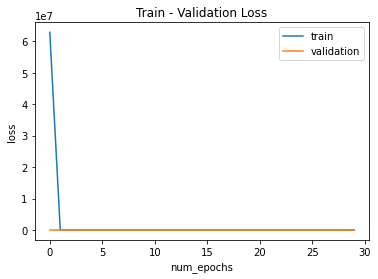

In [ ]:
plot_loss(train_loss, eval_loss)

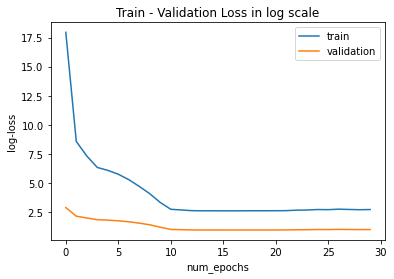

In [ ]:
#on logarithmic scale
plot_loss(train_loss, eval_loss, log=True)

In [ ]:
# Calculate mean squared error on test set
model.eval()
with torch.no_grad():
    y_pre_test = model(torch.from_numpy(np.array(X_test)).float())
    mu, var = y_pre_test[:, 0], torch.exp(y_pre_test[:, 1])
error = criterion(mu, torch.tensor(np.array(y_test)).float(), var).item()
print('The loss on test set is:', error)

The loss on test set is: 13.758419036865234


### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final loss value:  **we find 13.5**
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.

In [ ]:
# Calculate mean squared error on test set
model.eval()
with torch.no_grad():
    y_pre_test = model(torch.from_numpy(np.array(X_test)).float())
    mu, var = y_pre_test[:, 0], torch.exp(y_pre_test[:, 1])


In [ ]:
var.shape

torch.Size([260])

OverAllQual is the first feature in X_test

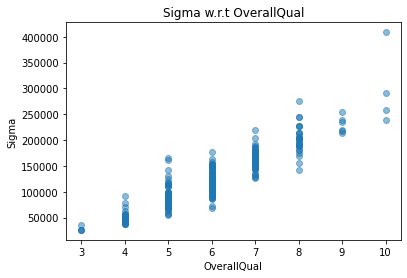

In [ ]:
sigma = np.array(torch.sqrt(var))
qual = X.iloc[1200:]['OverallQual'].values
# Plot
plt.scatter(qual, sigma , alpha=0.5)
plt.title('Sigma w.r.t OverallQual')
plt.xlabel('OverallQual')
plt.ylabel('Sigma')
plt.show()

In [ ]:
sigma

array([ 54578.19 , 164244.5  ,  75342.9  , 169138.81 ,  83539.234,
       204942.55 ,  62519.445, 152958.6  ,  87102.32 , 193744.66 ,
       147660.06 , 175141.58 ,  38484.656,  54537.605,  74412.67 ,
        70904.65 , 128782.914, 169972.05 ,  41871.22 , 102830.016,
        71220.59 ,  86143.64 , 131928.73 , 142262.19 , 149327.83 ,
        93143.22 , 153938.33 ,  71544.49 , 216827.95 ,  98796.766,
       165793.67 ,  85058.234,  56583.727,  84923.92 ,  98194.19 ,
        88454.58 , 155851.4  , 174561.62 , 116392.5  , 181243.95 ,
       165379.14 , 175215.77 , 127046.555, 259022.25 , 142739.47 ,
       138736.14 , 152415.45 , 100283.61 , 123582.086,  69298.21 ,
       192279.1  , 154303.58 ,  70364.13 , 182814.83 , 157140.6  ,
        97451.79 , 213124.4  ,  54321.668, 133620.39 ,  99417.64 ,
       137489.08 ,  76039.266,  91235.98 , 113015.22 , 128217.484,
       144302.53 , 135133.86 , 237953.   , 245450.02 ,  96145.19 ,
       152012.47 , 127382.37 ,  72781.3  , 110342.7  ,  62544.

If we see the data distribution on SalePrice w.r.t. OverallQual, the uncertainty of SalePrice will increases when OverallQual increases.In this is confirmed by the figure above, 𝜎(𝑥) is larger for samples with larger OverallQual.

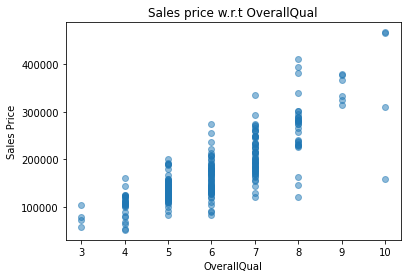

In [ ]:
#sns.pairplot(df, x_vars=['OverallQual'], y_vars=['SalePrice'])
plt.scatter(df['OverallQual'][1200:], df['SalePrice'][1200:] , alpha=0.5)
plt.title('Sales price w.r.t OverallQual')
plt.xlabel('OverallQual')
plt.ylabel('Sales Price')
plt.show()